# Import

In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math 
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2


import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)


import re
import pickle
import boto
from copy import deepcopy
import json
import os
import jinja2
import random
from tqdm import tqdm

from IPython.core.display import HTML

from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo


from anigen_tools.mturk import MTurk
from anigen_tools.mturk import pickle_this, unpickle_this

# data

In [9]:
gt_names = !ls ./data/user_study/groundtruth
nn_names = !ls ./data/user_study/nn
ours_names = !ls ./data/user_study/ours
pix2pix_names = !ls ./data/user_study/pix2pix/

# Setup - metric collection

In [2]:
from anigen_tools.annotation_collection import write_task_page
from anigen_tools.annotation_collection import generate_simpler_task_page

from anigen_tools.mturk import expected_cost

In [102]:
turk_account = mturk_ai2
rw_host='mechanicalturk.amazonaws.com'
amt_con = MTurk(turk_account.access_key, turk_account.access_secret_key, host=rw_host)
# amt_con = MTurk(turk_account.access_key, turk_account.access_secret_key)
amt_con.get_account_balance()

$207.64

# Submitting HITs- metric collection

In [94]:
static_params = {
    'title': "Select the image that's most similar to a given source image",
    'description': "You will be shown a source image and asked to select the most closely matching image from 3 options",
    'keywords': ['images'],
    'frame_height': 1000,
    'amount': 0.02,
    'duration': 3600 * 1,
    'lifetime': 3600 * 24 * 2,
    'max_assignments': 1,
    'locales': ['US', 'CA', 'AU', 'NZ', 'GB']
}

In [36]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/user_study/'

In [95]:
image_names= gt_names

In [40]:
from jinja2 import Environment, FileSystemLoader
from anigen_tools.annotation_collection import build_hit_params
import random

methods = ['nn', 'pix2pix', 'ours']

def generate_task_page(s3_base_path, img, template_file='stage_3a.html'):
    env = Environment(loader=FileSystemLoader('hit_templates'))
    template = env.get_template(template_file)
#     image_url = os.path.join(s3_base_path, 'gt', img)
    permute_methods = random.sample(methods, len(methods))
    page_html = template.render(s3_uri_base=s3_base_path, image_url=img, method1=permute_methods[0],  method2=permute_methods[1],  method3=permute_methods[2])
    page_html = page_html
    return page_html

def prepare_hit(s3_base_path, img_uri, static_parameters, task_generator=generate_task_page):
    question_html = task_generator(s3_base_path, img_uri)
    return build_hit_params(question_html, static_parameters)

In [103]:
build_hit_group = [prepare_hit(s3_base_path, img, static_params) for img in tqdm(image_names)]

write_task_page(random.choice(build_hit_group)['html'])
expected_cost(build_hit_group, static_params, amt_con)

100%|██████████| 4357/4357 [00:26<00:00, 165.13it/s]


87.14

In [100]:
87 * 1.2

104.39999999999999

**Procedure**

1. assure interface template is working

2. build and load ds skeleton for the sample to be submitted

3. make sure to sync images to s3

4. double check static params and host

5. build and submit

In [105]:
amt_con.get_account_balance()

$207.64

6638/9699

In [106]:
# hit_group = [amt_con.create_html_hit(single_hit) for single_hit in tqdm(build_hit_group)]

100%|██████████| 4357/4357 [16:28<00:00,  4.41it/s]


# Submit HITS- task b

In [31]:
static_params = {
    'title': "Locate objects in an animation frame",
    'description': 'Draw a bounding box for a particular object in a image.',
    'keywords': ['animation', 'image', 'bounding box','bounding boxes', 'image annotation'],
    'frame_height': 1000,
    'amount': 0.02,
    'duration': 3600 * 1,
    'lifetime': 3600 * 24 * 2,
    'max_assignments': 3,
    'locales': ['US', 'CA', 'AU', 'NZ', 'GB']
}

In [28]:
# s4a_go_vids = unpickle_this('../../build_dataset/s4a_rem_batch_3.pkl')
# s4a_go_vids = unpickle_this('../../build_dataset/have_4a_need_4b.pkl')
s4a_go_vids = unpickle_this('../../build_dataset/prod_2_3_4_have_4a_need_4b.pkl')

In [29]:
len(s4a_go_vids_go_vids)

12540

In [114]:
[(idx, vid) for idx, vid in enumerate(s4a_go_vids) if vid.gid() == 's_01_e_02_shot_021868_021942']

[(10261, {
      "characters": [
          {
              "entityLabel": "fred", 
              "globalID": "s_05_e_14_shot_016192_016266_char_0", 
              "labelNPC": "fred", 
              "rectangles": [
                  [], 
                  [
                      168, 
                      133, 
                      381, 
                      379
                  ], 
                  []
              ]
          }, 
          {
              "entityLabel": "barney", 
              "globalID": "s_05_e_14_shot_016192_016266_char_1", 
              "labelNPC": "barney", 
              "rectangles": [
                  [], 
                  [
                      367, 
                      171, 
                      526, 
                      367
                  ], 
                  []
              ]
          }
      ], 
      "description": "Fred and Barney are on a fishing boat. They are both wearing hats with fishing lures attached to them. Fred and Barney 

In [32]:
build_hit_group = []
for vid in tqdm(s4a_go_vids):
    build_hit_group.extend(prepare_stage_4b_hit(vid, static_params))

100%|██████████| 12540/12540 [01:11<00:00, 174.57it/s]


In [42]:
write_task_page(random.choice(build_hit_group)['html'])

In [97]:
len(build_hit_group)

23102

In [47]:
expected_cost(build_hit_group[19959:], static_params, amt_con)

188.58

In [51]:
# hit_group = [amt_con.create_html_hit(single_hit)   for single_hit in tqdm(build_hit_group[19959:])]

In [133]:
last_hids = [hit[0].HITId for hit in hit_group]

In [129]:
pd.Series(valid_s).value_counts()

True    3143
dtype: int64

In [140]:
retr_hits = [hit.HITId for hit in new_1b_hits]

In [141]:
inters  = set(last_hids).intersection(set(retr_hits))

In [142]:
len(inters)

0

In [147]:
trh1 = hit_group[0][0]

In [154]:
trh1.

# Retrieve results

In [61]:
from anigen_tools.annotation_collection import get_assignments
from anigen_tools.annotation_collection import filter_hits_by_date
from anigen_tools.annotation_collection import filter_hits_by_completion
from anigen_tools.annotation_collection import filter_hits_by_status
from anigen_tools.annotation_collection import get_completed_hits
from anigen_tools.annotation_collection import get_assignments
from anigen_tools.mturk import pickle_this

import datetime
import dateutil.parser as dt_parse

In [107]:
# %%time
# all_hits = amt_con.get_reviewable_hits(detailed=False)

In [163]:
%%time
all_hits = amt_con.get_all_hits()

start_date = (2018, 1, 23)
end_date = (2018, 1, 27)
recent_hits = filter_hits_by_date(all_hits, start_date, end_date)
recent_hits = filter_hits_by_status(recent_hits)

CPU times: user 2.08 s, sys: 60.5 ms, total: 2.14 s
Wall time: 32.2 s


In [164]:
len(recent_hits)

4355

In [145]:
len(build_hit_group)

4357

In [165]:
%%time
results = get_assignments(amt_con.connection, recent_hits)

CPU times: user 11.3 s, sys: 484 ms, total: 11.8 s
Wall time: 7min 52s


In [129]:
def create_result(assmt):
    result = json.loads(assmt.answers[0][0].fields[0])
    result['h_id'] = assmt.HITId
    result['a_id'] = assmt.AssignmentId
    result['worker_id'] = assmt.WorkerId
    return result

In [176]:
proc_results = []
for hid, ar in results.items():
    if ar:
        proc_results.append(create_result(ar[0]))

final_results = {v['image_url'].split('/')[-1]: v['selected_image'] for v in proc_results}
res_series = pd.Series(final_results)

In [177]:
res_series.value_counts()/res_series.shape[0] * 100

ours       69.804822
pix2pix    29.735936
nn          0.459242
dtype: float64

In [178]:
res_series.shape[0] / len(build_hit_group)

0.9995409685563461

In [156]:
res_series.to_json('user_study_results.json')

# all hit cleanup

In [8]:
all_thus_far = unpickle_this('latest_result_all_8_31.pkl')

In [34]:
all_hits = unpickle_this('stage_3_full_hits_8_31.pkl')

In [41]:
all_hits[0]

In [35]:
len(all_hits)

64326

In [9]:
len(all_thus_far)

64326

In [11]:
all_asgmts = [item for sublist in all_thus_far for item in sublist]

In [12]:
len(all_asgmts)

192045

In [13]:
ta1 = all_asgmts[0]

In [17]:
statuses = pd.Series([asgmt.AssignmentStatus for asgmt in all_asgmts])

In [ ]:
statuses = pd.Series([asgmt.AssignmentStatus for asgmt in all_asgmts])

In [42]:
pd.Series([len(hit) for hit in all_hits]).value_counts()

1    64326
dtype: int64

In [18]:
statuses.value_counts()

Approved     188099
Rejected       2173
Submitted      1773
dtype: int64

In [19]:
pending_asgmts = [asgmt for asgmt in all_asgmts if asgmt.AssignmentStatus == 'Submitted']

In [20]:
len(pending_asgmts)

1773

In [21]:
ta1.AcceptTime

u'2017-07-13T06:54:11Z'

In [26]:
accept_times = pd.Series([dt_parse.parse(asgmt.AcceptTime) for asgmt in pending_asgmts])

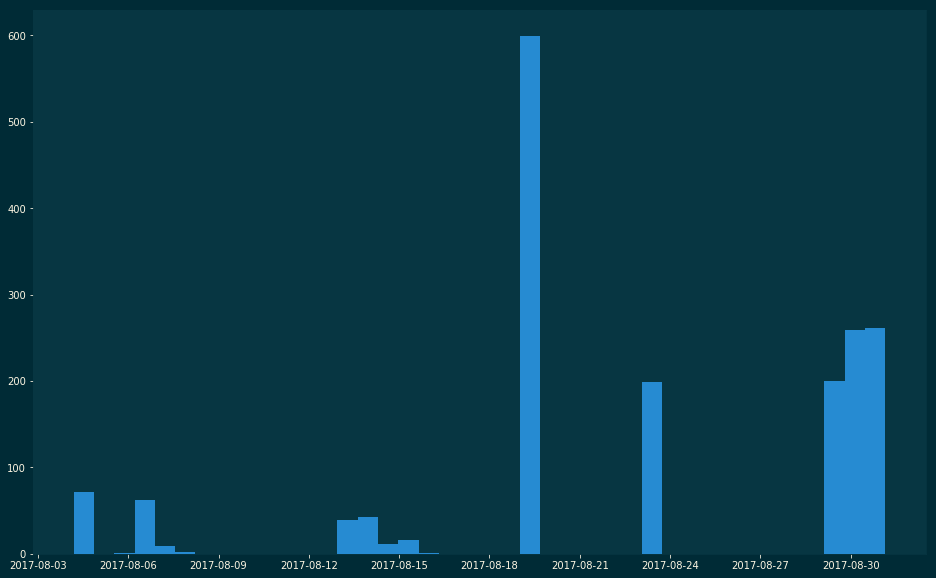

In [28]:
_ = accept_times.hist(bins = 40)

## check results

In [506]:
main_characters =  {"fred",
             "barney",
              "wilma",
              "betty",
              "pebbles",
              "bamm bamm",
              "dino",
              "mr slate",
              "baby puss",
              "hoppy",
              "empty frame",
              "no characters"}

def create_result(assmt):
    result = json.loads(assmt.answers[0][0].fields[0])
    result['h_id'] = assmt.HITId
    result['worker_id'] = assmt.WorkerId
    return result


def all_main(char_set, main_chars=main_characters):
    return not bool(char_set.difference(main_chars))

In [513]:
assignments =[]
for assignment_triple in list(results.values()):
    assignments.extend(assignment_triple)

assignment_results = [create_result(ar) for ar in assignments]
characters_present = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

In [514]:
characters_present

[{'characters': {u'judge'},
  'h_id': u'31S7M7DAGHQCUSQF0AU15OEW4LOLTV',
  'still_id': u's_06_e_04_shot_014628_014702_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'hoppy'},
  'h_id': u'3FI30CQHVLJUFLTRDKXEGBQD8LQ6BD',
  'still_id': u's_05_e_22_shot_037596_037670_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'wilma'},
  'h_id': u'35XW21VSVHEBFSD0BAPBVJIA22ALS6',
  'still_id': u's_02_e_29_shot_005091_005165_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'fred', u'wilma'},
  'h_id': u'3W3RSPVVGTRRU5540FKBAK0YNZVLUM',
  'still_id': u's_04_e_16_shot_018813_018887_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'barney', u'door', u'fred'},
  'h_id': u'3HUR21WDDVP3B86YOZKOOZ1YQY6YXD',
  'still_id': u's_01_e_24_shot_033229_033303_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'hat'},
  'h_id': u'3SMIWMMK62575ZH34TRDJVHEL8PUWI',
  'still_id': u's_02_e_08_shot_019539_019613_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'barney', u'roof'},


# Interact with workers

## reject assignments and ban workers

In [37]:
def ban_bad_workers(mturk_connection, worker_ids):
    for worker in worker_ids:
        reason_for_block = """
        Your HITs contained many frames with characters, but they were marked 'empty frame'
        """
        print('blocking ' + str(worker))
        mturk_connection.block_worker(worker, reason_for_block)

In [38]:
workers_to_ban = unpickle_this('workers_to_ban_prod_1_4.pkl')

In [39]:
workers_to_ban

{u'A13ISH3PAGHO0A',
 u'A15DOG6AXQ7LGY',
 u'A1CF1W8CP0DHB0',
 u'A1IOMFFEKCWOIT',
 u'A1QP6651C4Q8NS',
 u'A1RULXRXR2XF6M',
 u'A273GB71FE8RIV',
 u'A2CXEAMWU2SFV3',
 u'A2L97S8Z5FZK5N',
 u'A2NJTYYY37DNO',
 u'A2PU4YNWITAQVL',
 u'A2X7BE2FSPUKCK',
 u'A3R6KO03P9QLNO',
 u'A3UPV16IECELHV',
 u'A9ALF1SODWQE5'}

In [40]:
ban_bad_workers(amt_con.connection, list(workers_to_ban))

blocking A2PU4YNWITAQVL
blocking A273GB71FE8RIV
blocking A3R6KO03P9QLNO
blocking A2X7BE2FSPUKCK
blocking A1QP6651C4Q8NS
blocking A2CXEAMWU2SFV3
blocking A2NJTYYY37DNO
blocking A1CF1W8CP0DHB0
blocking A3UPV16IECELHV
blocking A2L97S8Z5FZK5N
blocking A1IOMFFEKCWOIT
blocking A15DOG6AXQ7LGY
blocking A9ALF1SODWQE5
blocking A1RULXRXR2XF6M
blocking A13ISH3PAGHO0A


In [46]:
to_reject = unpickle_this('assignments_to_reject_prod_1_4.pkl')

In [48]:
len(to_reject) * 0.04

378.16

In [43]:
def reject_assignments(mturk_connection, assignments_to_reject):
    feedback_message = """
    Your HITs contained many frames with characters, but they were marked 'empty frame'
    """
    reject_count = len(assignments_to_reject)
    for assignment_id in tqdm(assignments_to_reject):
        try:
            mturk_connection.reject_assignment(assignment_id, feedback_message)
        except boto.mturk.connection.MTurkRequestError:
            print('assignment ' + str(assignment_id) + ' already accepted or rejected')

    return reject_count

In [45]:
# reject_assignments(amt_con.connection, list(to_reject))

## pay bonuses

In [ ]:
subject = "More  HITs are available"
message = """
Hello, 

"""

In [ ]:
# _ = mturk.notify_workers(good_workers[:20], subject, message)

In [455]:
bonuses = unpickle_this('bonuses_to_pay_3.pkl')

In [458]:
def pay_bonuses(bonuses_to_pay):
    total_payed = 0
    bonus_reason_template = 'For Flinstones character labels written.'
    for aid, vals in tqdm(bonuses_to_pay.items()):
        n_chars = vals['count']
        wid = vals['worker_id']
        bonus_ammount = boto.mturk.price.Price(0.01 * n_chars)
        total_payed += bonus_ammount.amount
        bonus_reason = bonus_reason_template
        amt_con.connection.grant_bonus(wid, aid, bonus_ammount, bonus_reason)
    return total_payed

In [460]:
# pay_bonuses(bonuses)

# Accepting and deleting HITs

Uncomment only when ready to accept or delete hits

reject assignments carefully

In [166]:
assignments =[]
for assignment_triple in list(results.values()):
    assignments.extend(assignment_triple)

len(assignments)

4355

In [170]:
ta = assignments[-1]

u'Approved'

In [173]:
assignments_to_accept = [asgmt for asgmt in assignments if asgmt.AssignmentStatus != 'Approved']

In [174]:
len(assignments_to_accept)

23

In [175]:
e_count = 0
for assignment in tqdm(assignments_to_accept):
    try:
        amt_con.approve_assignment(assignment)
    except boto.mturk.connection.MTurkRequestError as e:
        e_count += 1

100%|██████████| 23/23 [00:04<00:00,  5.69it/s]


In [162]:
e_count

0

In [ ]:
print(e_count)

In [ ]:
# _ = [amt_con.disable_hit(hit) for hit in hits_today]

In [ ]:
# number_rejected_assignments, number_rejected_workers = amt_util.reject_assignments(mturk, workers_to_ban, combined_consensus_with_workerid_df)
# print 'rejecting ' + str(number_rejected_assignments) + ' assignments' + ' from ' + str(number_rejected_workers) + ' workers'

In [41]:
amt_con.get_account_balance()

$10,000.00

In [42]:
amt_con.delete_all_hits()

In [178]:
# _ = [amt_con.disable_hit(hit) for hit in tqdm(all_hits)]

In [43]:
e_count = 0
for hitid in tqdm(all_hits):
    try:
        amt_con.disable_hit(hitid[0])
    except boto.mturk.connection.MTurkRequestError as e:
        e_count += 1

100%|██████████| 64326/64326 [2:07:16<00:00,  6.91it/s]  
